# Assignment 2 : Financial Risk Assessment

## Import Statements

In [152]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import display
import copy

## Classes and Functions

In [153]:
class ID3Node:
    def __init__(self, feature=None, prediction=None, is_leaf=False, threshold=None):
        self.feature = feature               # Feature to split on

        self.children = {}                   # Dict in the form of : Categorical {feature_values: ID3Node}
                                             #                       Continuous {left, right: ID3Node}

        self.prediction = prediction         # Class label (every node has one prediction representing
                                             # the most common label in that branch)

        self.is_leaf = is_leaf               # Whether this node is a leaf

        self.threshold = threshold           # Binary split threshold for continuous features
                                             # (None for categorical features)


class ID3:
    def __init__(self, split_method="best", min_samples_split=2, min_samples_leaf=1):

        if split_method not in ["best", "median"]:
            raise ValueError(f"Invalid split_method '{split_method}'. Use 'best' or 'median'.")

        self.tree = None
        self.split_method = split_method # best or median
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf


    def entropy(self, y):
        val_counts = (pd.Series(y).value_counts()) / len(y)
        return -np.sum(val_counts * np.log2(val_counts))

    def information_gain(self, x_column, y, threshold=None):
        parent_entropy = self.entropy(y)

        # Categorical data
        if threshold is None:
            values, counts = np.unique(x_column, return_counts=True)
            weighted_entropy = 0
            for v, count in zip(values, counts):
                y_subset = y[x_column == v]
                weighted_entropy += (count / len(y)) * self.entropy(y_subset)
            return parent_entropy - weighted_entropy

        # Continuous data
        else:
            # Split from threshold (Binary Threshold)
            left = y[x_column <= threshold]
            right = y[x_column > threshold]

            # Discard split if there are less number of elements from min_samples_leaf in one of the splits
            if len(left) < self.min_samples_leaf or len(right) < self.min_samples_leaf:
                return -float('inf')

            weighted_entropy = 0
            weighted_entropy += (len(left) / len(y)) * self.entropy(left)
            weighted_entropy += (len(right) / len(y)) * self.entropy(right)
            return parent_entropy - weighted_entropy

    def best_feature(self, x, y):
        best_ig = -float('inf')
        best_feature = None
        best_threshold = None

        # Loop through each feature column in x
        for feature in x.columns:
            feature_values = x[feature]

            # Continuous feature
            if pd.api.types.is_numeric_dtype(feature_values):
                if self.split_method == "best":
                    attribute_values = np.sort(np.unique(feature_values))
                    # Calculate the mean of every two consecutive value to find thresholds
                    thresholds = (attribute_values[:-1] + attribute_values[1:]) / 2
                    # Calculate the information gain for every threshold to find the one with the most information gain for optimal binary split
                    for threshold in thresholds:
                        ig = self.information_gain(feature_values, y, threshold)
                        if ig > best_ig:
                            best_ig = ig
                            best_feature = feature
                            best_threshold = threshold
                else: # self.split_method == "median"
                    # Use the median for binary splitting to reduce computation
                    threshold = np.median(feature_values)
                    ig = self.information_gain(feature_values, y, threshold)
                    if ig > best_ig:
                        best_ig = ig
                        best_feature = feature
                        best_threshold = threshold
            # Categorical feature
            else:
                ig = self.information_gain(feature_values, y)
                if ig > best_ig:
                    best_ig = ig
                    best_feature = feature
                    best_threshold = None

        return best_feature, best_threshold

    def fit(self, x, y):
        self.tree = self._build_tree(x, y)

    def _build_tree(self, x, y):
        # If there is only one label left, return a leaf node
        if len(np.unique(y)) == 1:
            return ID3Node(prediction=y.iloc[0], is_leaf=True)

        # If no features left or there are not enough elements to split return the most common label
        if len(x.columns)  == 0 or len(y) < self.min_samples_split:
            most_common_label = y.mode()[0]
            return ID3Node(prediction=most_common_label, is_leaf=True)

        # Find the best feature to split it
        best_feature, threshold = self.best_feature(x, y)
        # Every node will have a prediction attribute which will be the most common label in that node
        most_common_label = y.mode()[0]

        # Create a node
        node = ID3Node(feature=best_feature, prediction=most_common_label, threshold=threshold)

        # Split the data based on the best feature and threshold

        # Categorical
        if threshold is None:
            for value in x[best_feature].unique():
                subset_x = x[x[best_feature] == value]
                subset_y = y[x[best_feature] == value]

                # If the best split will result in having fewer elements than min_samples_leaf, don't split it and mark that node as a leaf
                if len(subset_y) < self.min_samples_leaf:
                    child_node = ID3Node(prediction=most_common_label, is_leaf=True)
                else:
                    child_node = self._build_tree(subset_x.drop(columns=[best_feature]), subset_y)

                node.children[value] = child_node
        # Continuous
        else:
            left_x = x[x[best_feature] <= threshold]
            left_y = y[x[best_feature] <= threshold]
            right_x = x[x[best_feature] > threshold]
            right_y = y[x[best_feature] > threshold]

            # If the best split will result in having fewer elements than min_samples_leaf, don't split it and mark that node as a leaf
            if len(left_y) < self.min_samples_leaf or len(right_y) < self.min_samples_leaf:
                return ID3Node(prediction=most_common_label, is_leaf=True)

            left_node = self._build_tree(left_x.drop(columns=[best_feature]), left_y)
            right_node = self._build_tree(right_x.drop(columns=[best_feature]), right_y)
            node.children['left'] = left_node
            node.children['right'] = right_node

        return node

    def _predict_instance(self, x, node=None):

        if node is None:
            node = self.tree

        if node.is_leaf:
            return node.prediction

        feature_value = x[node.feature]

        # Continuous
        if node.threshold is not None:
            if feature_value <= node.threshold:
                return self._predict_instance(x, node.children['left'])
            else:
                return self._predict_instance(x, node.children['right'])

        # Categorical
        if feature_value in node.children:
            return self._predict_instance(x, node.children[feature_value])

        # If the feature value is not seen in the training set, use the most common label in this branch
        return node.prediction

    def predict(self, x):

        return x.apply(lambda row: self._predict_instance(row), axis=1)

def confusion_matrix(y_true, y_pred, labels=("Low", "Medium", "High")):
    indexes = {label: idx for idx, label in enumerate(labels)}

    cm = np.zeros((len(labels), len(labels)), dtype=int)

    for true, pred in zip(y_true, y_pred):
        cm[indexes[true], indexes[pred]] += 1

    return cm

def generate_heatmap(conf_matrix, title, class_labels=("Low", "Medium", "High")):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title(title)
    plt.show()

def compute_metrics(cm, labels=("Low", "Medium", "High")):
    # scikitlearn.classification_report inspired compute_metrics function

    num_classes = len(labels)

    precision = []
    recall = []
    f1_score = []
    support = cm.sum(axis=1)

    for i in range(num_classes):
        TP = cm[i, i]  # True Positives
        FP = cm[:, i].sum() - TP  # False Positives
        FN = cm[i, :].sum() - TP  # False Negatives

        # Compute metrics (also handle division by zero error)
        prec = TP / (TP + FP) if (TP + FP) > 0 else 0
        rec = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

        precision.append(prec)
        recall.append(rec)
        f1_score.append(f1)

    # Compute overall accuracy
    accuracy = np.trace(cm) / cm.sum()

    # Accuracy row
    accuracy_row = [0.0, 0.0, accuracy, sum(support)]

    # Compute macro and weighted averages
    macro_avg = [np.mean(precision), np.mean(recall), np.mean(f1_score), sum(support)]
    weighted_avg = [np.average(precision, weights=support), np.average(recall, weights=support), np.average(f1_score, weights=support), sum(support)]

    # Create the report as a DataFrame
    report_df = pd.DataFrame(
        data={
            "precision": precision + [accuracy_row[0], macro_avg[0], weighted_avg[0]],
            "recall": recall + [accuracy_row[1], macro_avg[1], weighted_avg[1]],
            "f1-score": f1_score + [accuracy_row[2], macro_avg[2], weighted_avg[2]],
            "support": support.tolist() + [accuracy_row[3], macro_avg[3], weighted_avg[3]],
        },
        index=list(labels) + ["accuracy", "macro avg", "weighted avg"],
    )

    return report_df.round(2)

def draw_box_plots(dataframe, title="Box Plots of Numeric Features"):

    numeric_cols = dataframe.select_dtypes(include='number')

    num_features = numeric_cols.shape[1]

    cols = 5
    rows = 2

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols.columns):
        sns.boxplot(y=numeric_cols[col], ax=axes[i], color='skyblue')
        axes[i].set_title(col, fontsize=12)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

    # Turn off extra subplots if any
    for j in range(num_features, len(axes)):
        axes[j].axis('off')

    plt.suptitle(title, fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def print_decision_rules(tree):
    rules = []

    def traverse(node, conditions):
        if node.is_leaf:
            rule = "IF " + " & ".join(conditions) if conditions else "IF True"
            rule += f" THEN Class={node.prediction}"
            rules.append(rule)
            return

        feature = node.feature

        if node.threshold is not None:
            # Continuous feature: create left and right conditions
            left_condition = f"({feature} <= {round(node.threshold, 3)})"
            right_condition = f"({feature} > {round(node.threshold, 3)})"

            traverse(node.children["left"], conditions + [left_condition])
            traverse(node.children["right"], conditions + [right_condition])
        else:
            # Categorical feature: iterate over all children
            for value, child in node.children.items():
                condition = f"({feature} = {value})"
                traverse(child, conditions + [condition])

    traverse(tree, [])

    # Print all rules with rule numbers
    for idx, rule in enumerate(rules, start=1):
        print(f"R{idx}: {rule}")

## Part 1: Implementing Decision Tree

The implementation of the "ID3" tree can be found on the "Classes and Functions" section. Some of the important details of this tree is listed below.

The tree can handle both categorical and continuous data. Binary thresholding is used to split the continuous data. There is a hyperparameter called "split_method" which can be set to "best" or "median". It changes how the threshold is chosen. If "best" is used, then thresholds are chosen by taking the mean every two consecutive values of an attribute. Then an optimal threshold is chosen by trying each threshold to find the one that will have the most information gain. If "median" is used, then the median of that feature is used as the threshold.

There are two more hyperparameters which can be set, "min_samples_split" and "min_samples_leaf". "min_samples_split" is the minimum number of samples in a node to be split again by a feature. "min_samples_leaf" is the minimum number of samples in a leaf. These two are implemented with the thought of doing some generalization in the tree without pruning it too much.

The "max_depth" parameter is avoided intentionally as we will prune the trees that we get from part 1. The trees that we will fit in this section will be generally tight fits to the training data to allow the pruning process to be effective.

The encoding of the labels is not needed as pandas dataframes and series are used to fit the model and make predictions. They carry the label name information with them, so encoding and decoding is not necessary.

### Data Analysis

When we analyze our data, we can see that we have 19 feature columns and 1 target column which is the "Risk Rating". "Risk Rating" is categorized between "Low", "Medium" and "High". 10 of the features are numerical and 9 of them are categorical. Also, it can be seen that there are missing values in some of the columns that will need some handling. We can also see that some of the categorical values have too many categories which can be a problem. Finally, analyzing the correlation map, we can see that none of the numerical values are correlated with each other.

In [154]:
df = pd.read_csv("data/financial_risk_assessment.csv")

In [155]:
df.head()

,Age,Gender,Education Level,Marital Status,Income,Credit Score,Loan Amount,Loan Purpose,Employment Status,Years at Current Job,Payment History,Debt-to-Income Ratio,Assets Value,Number of Dependents,City,State,Country,Previous Defaults,Marital Status Change,Risk Rating
0,49,Male,PhD,Divorced,72799.0,688.0,45713.0,Business,Unemployed,19,Poor,0.154313,120228.0,0.0,Port Elizabeth,AS,Cyprus,2.0,2,Low
1,57,Female,Bachelor's,Widowed,NaN,690.0,33835.0,Auto,Employed,6,Fair,0.148920,55849.0,0.0,North Catherine,OH,Turkmenistan,3.0,2,Medium
2,21,Non-binary,Master's,Single,55687.0,600.0,36623.0,Home,Employed,8,Fair,0.362398,180700.0,3.0,South Scott,OK,Luxembourg,3.0,2,Medium
3,59,Male,Bachelor's,Single,26508.0,622.0,26541.0,Personal,Unemployed,2,Excellent,0.454964,157319.0,3.0,Robinhaven,PR,Uganda,4.0,2,Medium
4,25,Non-binary,Bachelor's,Widowed,49427.0,766.0,36528.0,Personal,Unemployed,10,Fair,0.143242,287140.0,NaN,New Heather,IL,Namibia,3.0,1,Low


In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    15000 non-null  int64  
 1   Gender                 15000 non-null  object 
 2   Education Level        15000 non-null  object 
 3   Marital Status         15000 non-null  object 
 4   Income                 12750 non-null  float64
 5   Credit Score           12750 non-null  float64
 6   Loan Amount            12750 non-null  float64
 7   Loan Purpose           15000 non-null  object 
 8   Employment Status      15000 non-null  object 
 9   Years at Current Job   15000 non-null  int64  
 10  Payment History        15000 non-null  object 
 11  Debt-to-Income Ratio   15000 non-null  float64
 12  Assets Value           12750 non-null  float64
 13  Number of Dependents   12750 non-null  float64
 14  City                   15000 non-null  object 
 15  St

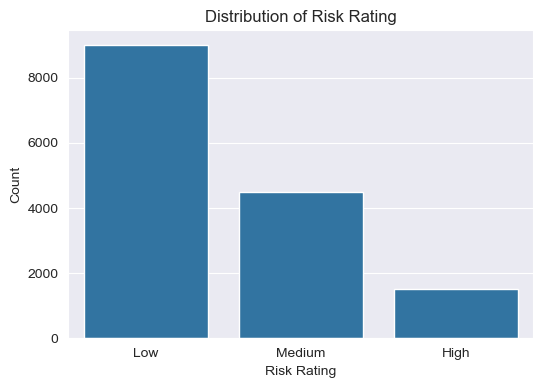

In [157]:
# Show histograms for the target class 'Risk Rating'
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Risk Rating')
plt.title('Distribution of Risk Rating')
plt.xlabel('Risk Rating')
plt.ylabel('Count')
plt.show()

In [158]:
df.describe(include=[np.number])

,Age,Income,Credit Score,Loan Amount,Years at Current Job,Debt-to-Income Ratio,Assets Value,Number of Dependents,Previous Defaults,Marital Status Change
count,15000.000000,12750.000000,12750.000000,12750.000000,15000.000000,15000.000000,12750.000000,12750.00000,12750.000000,15000.000000
mean,43.452667,69933.398510,699.109098,27450.010902,9.476267,0.350438,159741.497176,2.02651,1.992471,0.998467
std,14.910732,29163.626207,57.229465,12949.940135,5.769707,0.143919,80298.115832,1.41130,1.416909,0.813782
min,18.000000,20005.000000,600.000000,5000.000000,0.000000,0.100004,20055.000000,0.00000,0.000000,0.000000
25%,31.000000,44281.500000,650.000000,16352.500000,4.000000,0.227386,90635.250000,1.00000,1.000000,0.000000
50%,43.000000,69773.000000,699.000000,27544.000000,9.000000,0.350754,159362.000000,2.00000,2.000000,1.000000
75%,56.000000,95922.750000,748.000000,38547.500000,15.000000,0.476095,228707.000000,3.00000,3.000000,2.000000
max,69.000000,119997.000000,799.000000,49998.000000,19.000000,0.599970,299999.000000,4.00000,4.000000,2.000000


In [159]:
df.describe(include=[object])

,Gender,Education Level,Marital Status,Loan Purpose,Employment Status,Payment History,City,State,Country,Risk Rating
count,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000
unique,3,4,4,4,3,4,10614,59,243,3
top,Non-binary,Bachelor's,Widowed,Personal,Employed,Good,East Michael,CO,Congo,Low
freq,5059,3829,3893,3771,5026,3822,19,282,124,9000


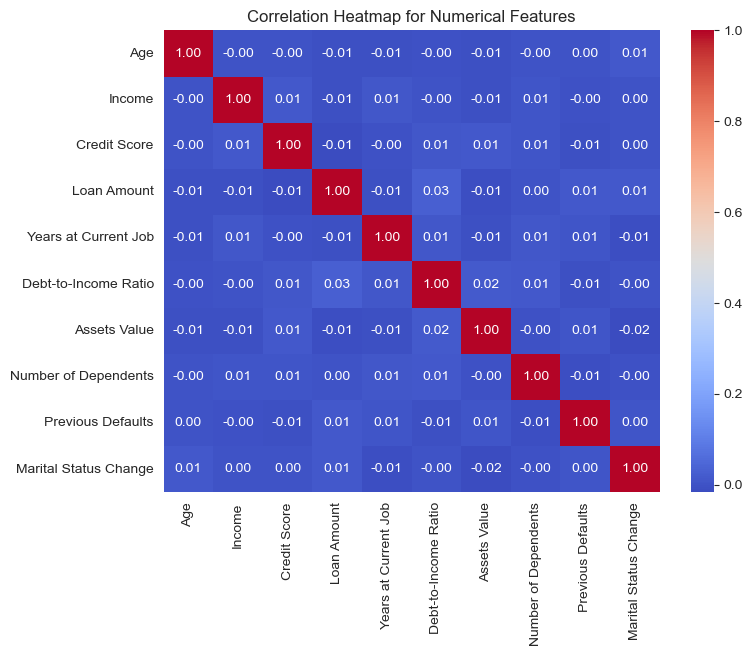

In [160]:
# Correlation heatmap for numerical features
numerical_features = df.select_dtypes(include='number').columns

plt.figure(figsize=(8,6))
correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap for Numerical Features')
plt.show()

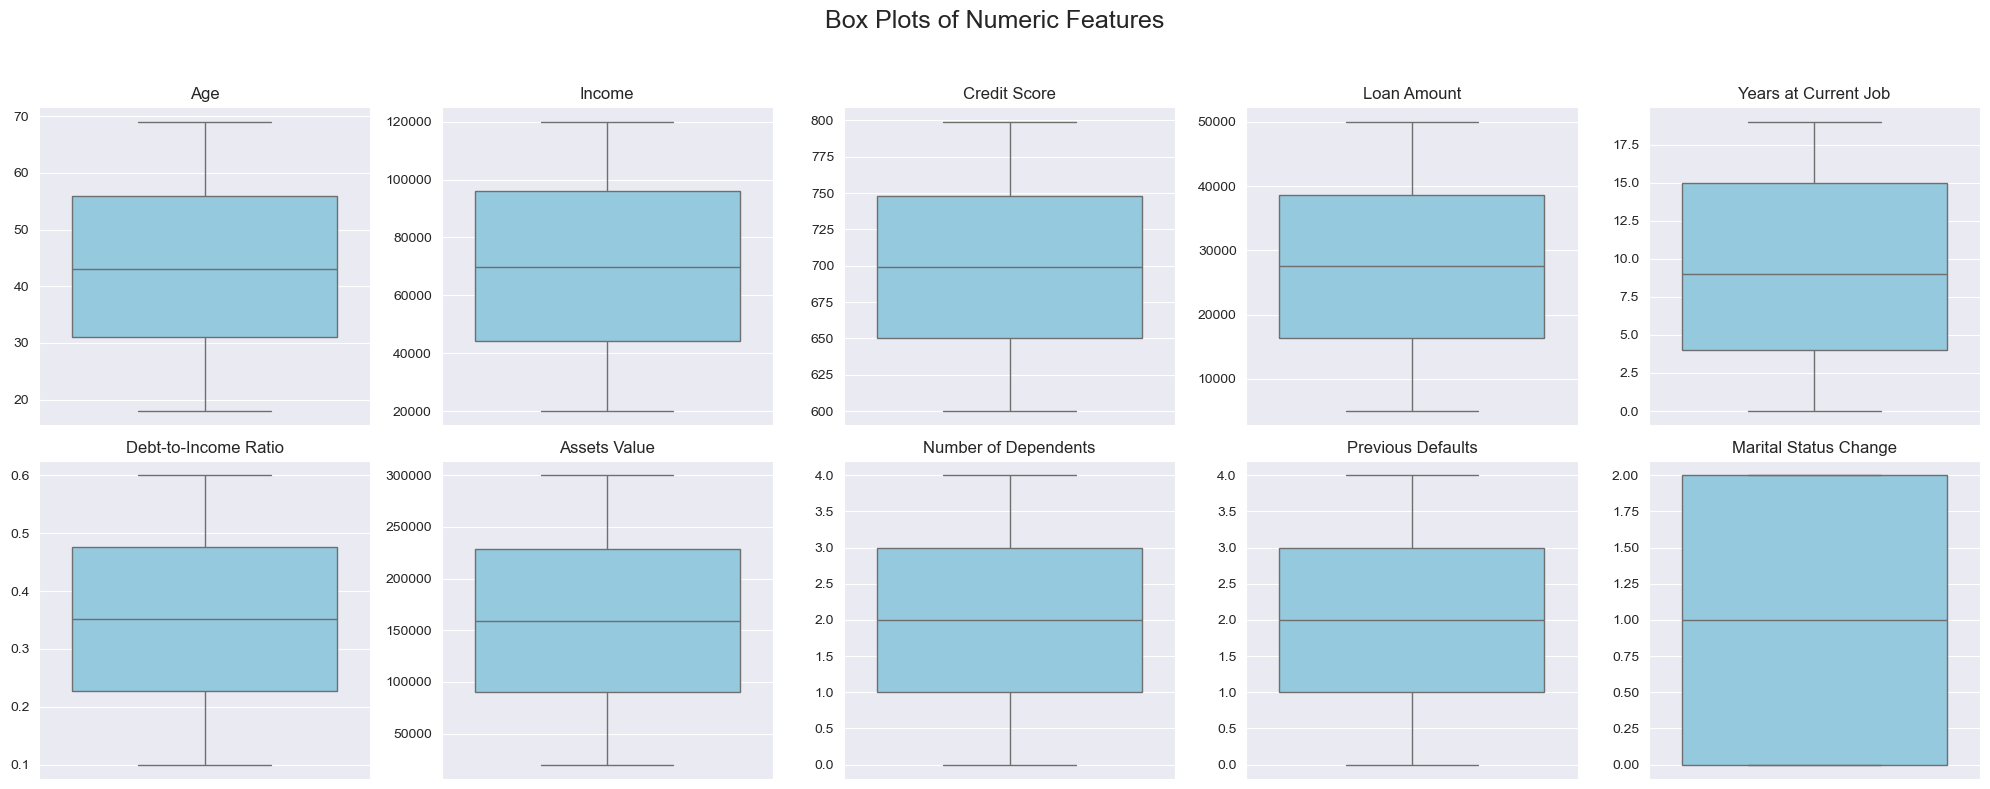

In [161]:
# Box Plots for Numeric Features
draw_box_plots(df)

### Data Preprocessing

Data scaling will not be done in this section as decision trees in general (thus ID3 tree as well) does not benefit from scaling as some of the other algorithms (linear regression, KNN). The threshold for continuous values are chosen in a way that it is more involved with how the data is split compared to the actual values. Since scaling doesn't change the properties of the continuous data, they will be split the same way either they are scaled before or not.

When we analysed the data, we saw that "City" feature has 10614 unique values and our data has 15000 rows. It is clear that we don't have enough rows for the "City" feature to be relevant. Furthermore, leaving this feature in could lead to overfitting the tree. "City" feature will give high information gain as it will separate the data well. However, it will be a very poor predictor for unseen data. Thus, this feature is decided to be dropped for all of the different preprocessed data.

In [162]:
df = df.drop("City", axis=1)

Two different methods are used for handling the missing data in some of the columns. One is to drop all the rows with missing values. The other one is to assign the median value of the missing attribute grouped by the target class ("Risk Rating"). From our data analysis, we know that only numerical features have missing values.

In [163]:
df_dropped = df.copy()
df_dropped = df_dropped.dropna()

df_filled = df.copy()
cols_with_missing_values = df_filled.columns[df_filled.isnull().sum() > 0].tolist()
for col in cols_with_missing_values:
    if pd.api.types.is_numeric_dtype(df_filled[col].dtype):  # numeric
        df_filled[col] = df_filled.groupby("Risk Rating")[col].transform(
            lambda group: group.fillna(group.median())
        )

In [164]:
x_dropped = df_dropped.iloc[:, :-1]
y_dropped = df_dropped.iloc[:, -1]

x_filled = df_filled.iloc[:, :-1]
y_filled = df_filled.iloc[:, -1]

In [165]:
x_dropped_train, x_dropped_temp, y_dropped_train, y_dropped_temp = train_test_split(x_dropped, y_dropped, test_size=0.30, random_state=42, shuffle=True)
x_dropped_test, x_dropped_val, y_dropped_test, y_dropped_val = train_test_split(x_dropped_temp, y_dropped_temp, test_size=0.50, random_state=42, shuffle=True)

x_filled_train, x_filled_temp, y_filled_train, y_filled_temp = train_test_split(x_filled, y_filled, test_size=0.30, random_state=42, shuffle=True)
x_filled_test, x_filled_val, y_filled_test, y_filled_val = train_test_split(x_filled_temp, y_filled_temp, test_size=0.50, random_state=42, shuffle=True)


### Model Evaluation

In this section, different trees will be generated using different hyperparameters and two different preprocessed data.

Tree 1 - 2 are trees that fit the training data perfectly. They are overfitted and need pruning.

Tree 3 - 4 are somewhat more generalized due to usage of the hyperparameters min_samples_split and min_samples_leaf.

Tree 5 uses "best" and Tree 4 uses "median" as the split_method. Using the "best" method for split did not change anything as Tree 5 is exactly the same as Tree 4. Moreover, there is a downside that "best" method takes around ten times more time than "median" method as it is computationally more expensive. In this case, it is better to use "median".

If we look at Tree 3 - 4, generalizing the tree gives somehow better results. However, it can be seen also be seen that most of the leafs start to get "Low" label as the models try to predict more and more of the class "Low". From the "Data Analysis" section, we know that "Low" class label makes up approximately %60 of all the "Risk Rating" target feature. Since there is more from one target class, it is natural that when generalizing it, that class gets more leafs.

#### Tree 1 - %100 fit to the train data using df_dropped

In [166]:
id3_1 = ID3(split_method="median", min_samples_split=2, min_samples_leaf=1)
id3_1.fit(x_dropped_train, y_dropped_train)
y_1_dropped_train_pred = id3_1.predict(x_dropped_train)
y_1_dropped_pred = id3_1.predict(x_dropped_test)

In [167]:
print("Evaluation Metrics for Tree 1 - Train Data")
cm_1_train = confusion_matrix(y_dropped_train, y_1_dropped_train_pred)
compute_metrics(cm_1_train)

Evaluation Metrics for Tree 1 - Train Data


,precision,recall,f1-score,support
Low,1.0,1.0,1.0,2378
Medium,1.0,1.0,1.0,1221
High,1.0,1.0,1.0,402
accuracy,0.0,0.0,1.0,4001
macro avg,1.0,1.0,1.0,4001
weighted avg,1.0,1.0,1.0,4001


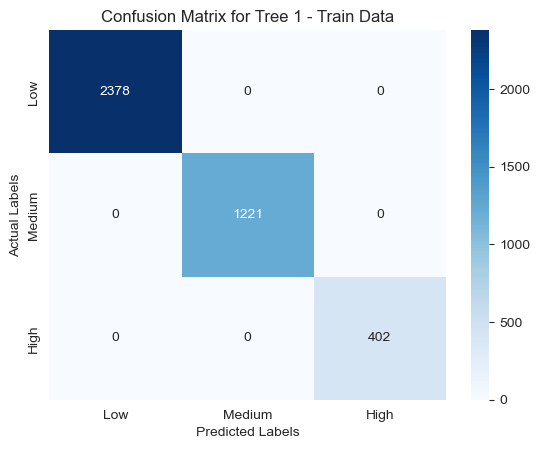

In [168]:
generate_heatmap(cm_1_train, "Confusion Matrix for Tree 1 - Train Data")

In [169]:
print("Evaluation Metrics for Tree 1 - Test Data")
cm_1_test = confusion_matrix(y_dropped_test, y_1_dropped_pred)
compute_metrics(cm_1_test)

Evaluation Metrics for Tree 1 - Test Data


,precision,recall,f1-score,support
Low,0.63,0.87,0.73,527
Medium,0.30,0.13,0.18,249
High,0.10,0.02,0.04,81
accuracy,0.00,0.00,0.57,857
macro avg,0.34,0.34,0.32,857
weighted avg,0.48,0.57,0.50,857


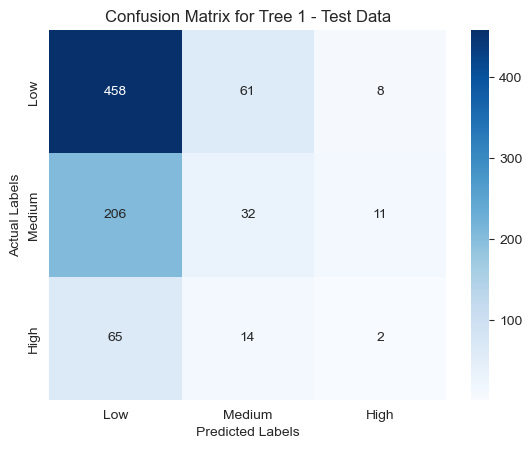

In [170]:
generate_heatmap(cm_1_test, "Confusion Matrix for Tree 1 - Test Data")

#### Tree 2 - %100 fit to the train data using df_filled

In [171]:
id3_2 = ID3(split_method="median", min_samples_split=2, min_samples_leaf=1)
id3_2.fit(x_filled_train, y_filled_train)
y_2_filled_train_pred = id3_2.predict(x_filled_train)
y_2_filled_pred = id3_2.predict(x_filled_test)

In [172]:
print("Evaluation Metrics for Tree 2 - Train Data")
cm_2_train = confusion_matrix(y_filled_train, y_2_filled_train_pred)
compute_metrics(cm_2_train)

Evaluation Metrics for Tree 2 - Train Data


,precision,recall,f1-score,support
Low,1.0,1.0,1.0,6308
Medium,1.0,1.0,1.0,3162
High,1.0,1.0,1.0,1030
accuracy,0.0,0.0,1.0,10500
macro avg,1.0,1.0,1.0,10500
weighted avg,1.0,1.0,1.0,10500


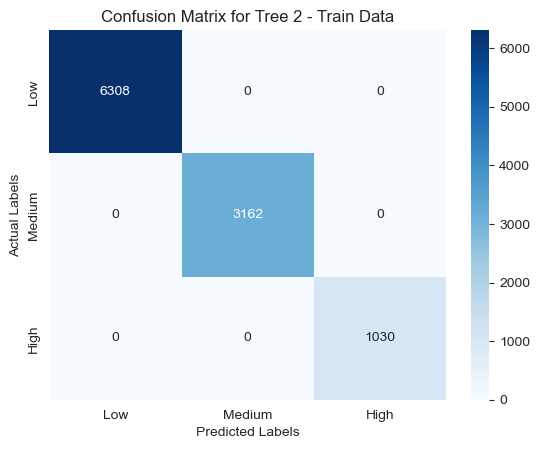

In [173]:
generate_heatmap(cm_2_train, "Confusion Matrix for Tree 2 - Train Data")

In [174]:
print("Evaluation Metrics for Tree 2 - Test Data")
cm_2_test = confusion_matrix(y_filled_test, y_2_filled_pred)
compute_metrics(cm_2_test)

Evaluation Metrics for Tree 2 - Test Data


,precision,recall,f1-score,support
Low,0.60,0.79,0.68,1342
Medium,0.31,0.16,0.21,667
High,0.12,0.07,0.09,241
accuracy,0.00,0.00,0.53,2250
macro avg,0.34,0.34,0.33,2250
weighted avg,0.46,0.53,0.48,2250


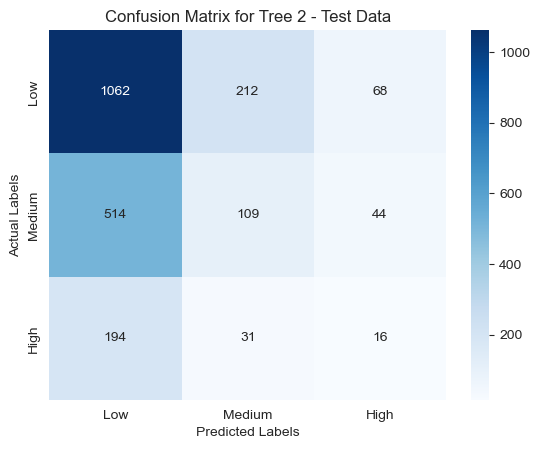

In [175]:
generate_heatmap(cm_2_test, "Confusion Matrix for Tree 2 - Test Data")

#### Tree 3 - split_method = "median" & min_samples_split = 5 & min_samples_leaf = 2 using df_filled

In [176]:
id3_3 = ID3(split_method="median", min_samples_split=5, min_samples_leaf=2)
id3_3.fit(x_filled_train, y_filled_train)
y_3_filled_train_pred = id3_3.predict(x_filled_train)
y_3_filled_pred = id3_3.predict(x_filled_test)

In [177]:
print("Evaluation Metrics for Tree 3 - Train Data")
cm_3_train = confusion_matrix(y_filled_train, y_3_filled_train_pred)
compute_metrics(cm_3_train)

Evaluation Metrics for Tree 3 - Train Data


,precision,recall,f1-score,support
Low,0.67,0.93,0.78,6308
Medium,0.80,0.20,0.32,3162
High,0.49,0.45,0.47,1030
accuracy,0.00,0.00,0.66,10500
macro avg,0.65,0.53,0.52,10500
weighted avg,0.69,0.66,0.61,10500


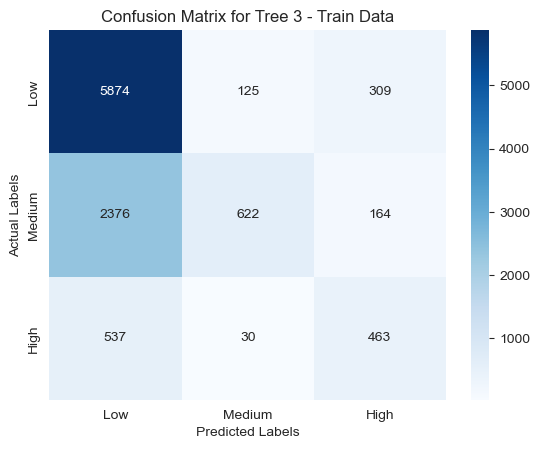

In [178]:
generate_heatmap(cm_3_train, "Confusion Matrix for Tree 3 - Train Data")

In [179]:
print("Evaluation Metrics for Tree 3 - Test Data")
cm_3_test = confusion_matrix(y_filled_test, y_3_filled_pred)
compute_metrics(cm_3_test)

Evaluation Metrics for Tree 3 - Test Data


,precision,recall,f1-score,support
Low,0.59,0.93,0.73,1342
Medium,0.21,0.02,0.04,667
High,0.12,0.03,0.05,241
accuracy,0.00,0.00,0.57,2250
macro avg,0.31,0.33,0.27,2250
weighted avg,0.43,0.57,0.45,2250


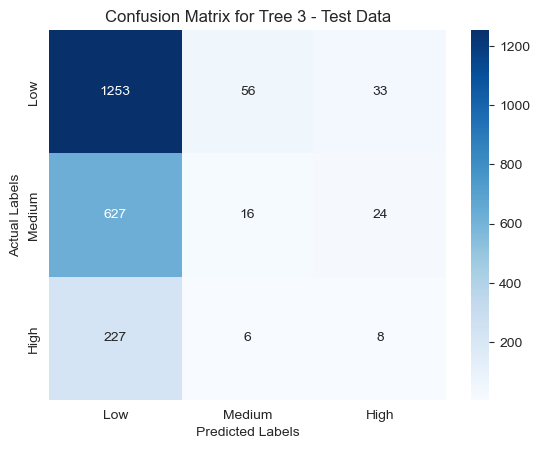

In [180]:
generate_heatmap(cm_3_test, "Confusion Matrix for Tree 3 - Test Data")

#### Tree 4 - split_method = "median" & min_samples_split = 10 & min_samples_leaf = 3 using df_filled

In [181]:
id3_4 = ID3(split_method="median", min_samples_split=10, min_samples_leaf=3)
id3_4.fit(x_filled_train, y_filled_train)
y_4_filled_train_pred = id3_4.predict(x_filled_train)
y_4_filled_pred = id3_4.predict(x_filled_test)

In [182]:
print("Evaluation Metrics for Tree 4 - Train Data")
cm_4_train = confusion_matrix(y_filled_train, y_4_filled_train_pred)
compute_metrics(cm_4_train)

Evaluation Metrics for Tree 4 - Train Data


,precision,recall,f1-score,support
Low,0.62,0.96,0.76,6308
Medium,0.63,0.11,0.18,3162
High,0.40,0.09,0.14,1030
accuracy,0.00,0.00,0.62,10500
macro avg,0.55,0.39,0.36,10500
weighted avg,0.60,0.62,0.52,10500


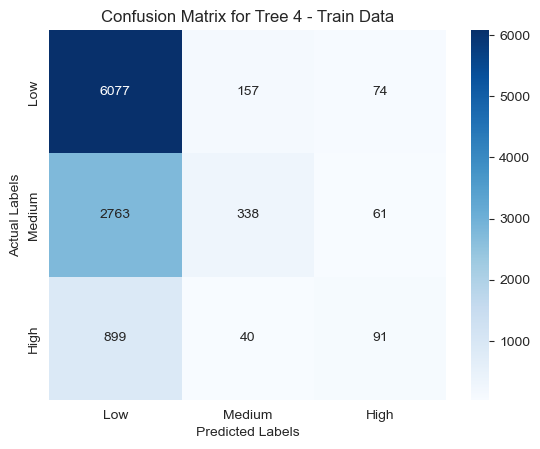

In [183]:
generate_heatmap(cm_4_train, "Confusion Matrix for Tree 4 - Train Data")

In [184]:
print("Evaluation Metrics for Tree 4 - Test Data")
cm_4_test = confusion_matrix(y_filled_test, y_4_filled_pred)
compute_metrics(cm_4_test)

Evaluation Metrics for Tree 4 - Test Data


,precision,recall,f1-score,support
Low,0.59,0.96,0.74,1342
Medium,0.25,0.02,0.04,667
High,0.00,0.00,0.00,241
accuracy,0.00,0.00,0.58,2250
macro avg,0.28,0.33,0.26,2250
weighted avg,0.43,0.58,0.45,2250


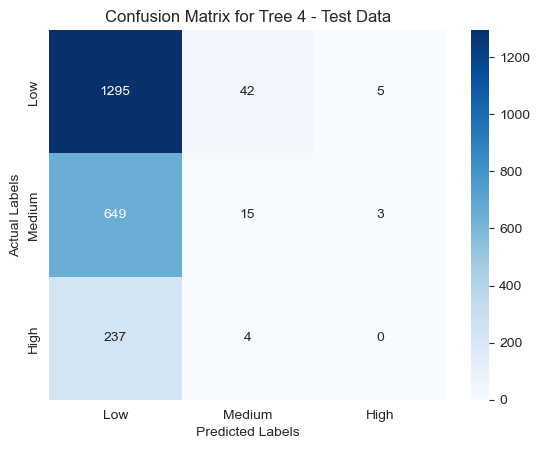

In [185]:
generate_heatmap(cm_4_test, "Confusion Matrix for Tree 4 - Test Data")

#### Tree 5 - split_method = "best" & min_samples_split = 10 & min_samples_leaf = 3 using df_filled

In [186]:
id3_5 = ID3(split_method="best", min_samples_split=10, min_samples_leaf=3)
id3_5.fit(x_filled_train, y_filled_train)
y_5_filled_train_pred = id3_5.predict(x_filled_train)
y_5_filled_pred = id3_5.predict(x_filled_test)

In [187]:
print("Evaluation Metrics for Tree 5 - Train Data")
cm_5_train = confusion_matrix(y_filled_train, y_5_filled_train_pred)
compute_metrics(cm_5_train)

Evaluation Metrics for Tree 5 - Train Data


,precision,recall,f1-score,support
Low,0.62,0.96,0.76,6308
Medium,0.63,0.11,0.18,3162
High,0.40,0.09,0.14,1030
accuracy,0.00,0.00,0.62,10500
macro avg,0.55,0.39,0.36,10500
weighted avg,0.60,0.62,0.52,10500


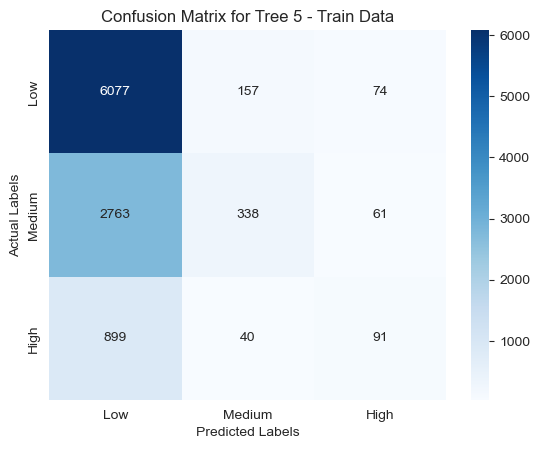

In [188]:
generate_heatmap(cm_5_train, "Confusion Matrix for Tree 5 - Train Data")

In [189]:
print("Evaluation Metrics for Tree 5 - Test Data")
cm_5_test = confusion_matrix(y_filled_test, y_5_filled_pred)
compute_metrics(cm_5_test)

Evaluation Metrics for Tree 5 - Test Data


,precision,recall,f1-score,support
Low,0.59,0.96,0.74,1342
Medium,0.25,0.02,0.04,667
High,0.00,0.00,0.00,241
accuracy,0.00,0.00,0.58,2250
macro avg,0.28,0.33,0.26,2250
weighted avg,0.43,0.58,0.45,2250


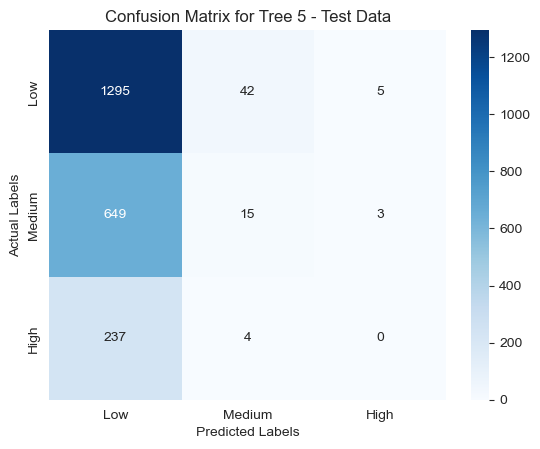

In [190]:
generate_heatmap(cm_5_test, "Confusion Matrix for Tree 5 - Test Data")

## Part 2: Pruning Decision Tree

In this study, four decision trees (Tree 1 to Tree 4) were trained and evaluated using different preprocessing methods and hyperparameters. Tree 1 was trained on a dataset with missing values dropped, while Trees 2–4 were trained on a dataset with imputed (filled) values. Each model was evaluated using a test set both before (in Part 1) and after applying post-pruning, in order to measure its effect on overfitting and generalization performance.

Tree 5 was excluded from pruning since it had the same structure and hyperparameters as Tree 4, except for using "best" instead of "median" as the split method. As it produced a nearly identical tree depth and predictions, pruning it was considered redundant.


In [191]:
def prune_tree(model, node, x_val, y_val):

    if node.is_leaf:
        return

    # Prune children first (bottom-up approach)
    for key, child in node.children.items():
        prune_tree(model, child, x_val, y_val)

    # Predict before pruning
    predictions_before = model.predict(x_val)
    acc_before = np.mean(predictions_before == y_val)

    # Try to convert this node into a leaf
    original_children = node.children
    original_is_leaf = node.is_leaf
    original_feature = node.feature
    original_threshold = node.threshold

    node.children = {}
    node.is_leaf = True
    node.feature = None
    node.threshold = None

    # Predict after pruning
    predictions_after = model.predict(x_val)
    acc_after = np.mean(predictions_after == y_val)

    # If accuracy didn’t improve, rollback pruning
    if acc_after < acc_before:
        node.children = original_children
        node.is_leaf = original_is_leaf
        node.feature = original_feature
        node.threshold = original_threshold


Note: In the evaluation tables below, the “accuracy” row displays the actual accuracy value under the F1-score column, while precision and recall values appear as zero due to formatting limitations.

#### Tree 1

In [192]:
tree1_clone = copy.deepcopy(id3_1)

In [193]:
print("🔹 Tree 1 - Pre-Pruning")
compute_metrics(cm_1_test)

🔹 Tree 1 - Pre-Pruning


,precision,recall,f1-score,support
Low,0.63,0.87,0.73,527
Medium,0.30,0.13,0.18,249
High,0.10,0.02,0.04,81
accuracy,0.00,0.00,0.57,857
macro avg,0.34,0.34,0.32,857
weighted avg,0.48,0.57,0.50,857


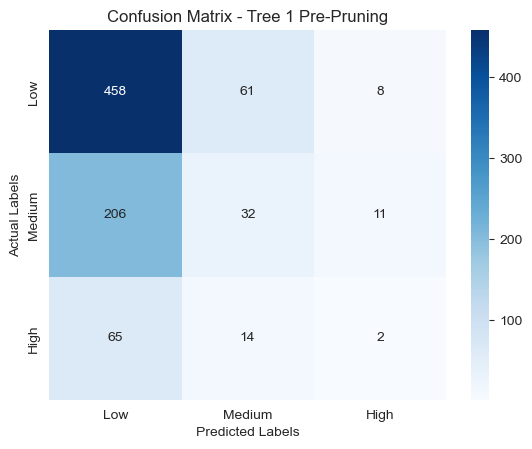

In [194]:
generate_heatmap(cm_1_test, "Confusion Matrix - Tree 1 Pre-Pruning")

In [195]:
prune_tree(tree1_clone, tree1_clone.tree, x_dropped_test, y_dropped_test)

In [196]:
print("🔹 Tree 1 - Post-Pruning")
y_val_pred_after = tree1_clone.predict(x_dropped_test)
cm_after = confusion_matrix(y_dropped_test, y_val_pred_after)
display(compute_metrics(cm_after))

🔹 Tree 1 - Post-Pruning


,precision,recall,f1-score,support
Low,0.64,0.96,0.77,527
Medium,0.58,0.14,0.22,249
High,0.22,0.02,0.04,81
accuracy,0.00,0.00,0.63,857
macro avg,0.48,0.37,0.34,857
weighted avg,0.58,0.63,0.54,857


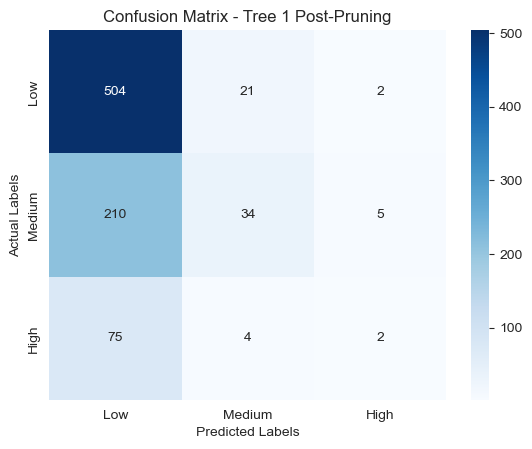

In [197]:
generate_heatmap(cm_after, "Confusion Matrix - Tree 1 Post-Pruning")

#### Tree 2

In [198]:
tree2_clone = copy.deepcopy(id3_2)

In [199]:
print("🔹 Tree 2 - Pre-Pruning")
compute_metrics(cm_2_test)

🔹 Tree 2 - Pre-Pruning


,precision,recall,f1-score,support
Low,0.60,0.79,0.68,1342
Medium,0.31,0.16,0.21,667
High,0.12,0.07,0.09,241
accuracy,0.00,0.00,0.53,2250
macro avg,0.34,0.34,0.33,2250
weighted avg,0.46,0.53,0.48,2250


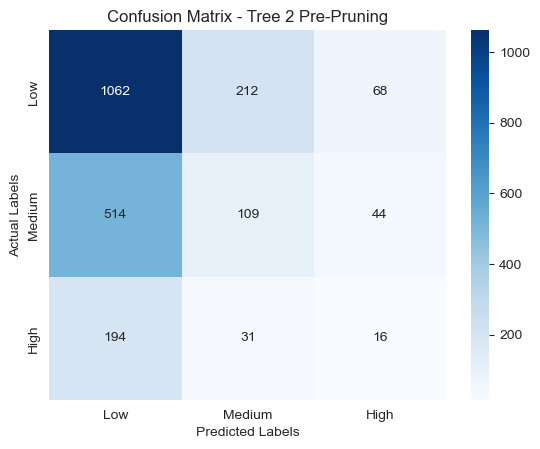

In [200]:
generate_heatmap(cm_2_test, "Confusion Matrix - Tree 2 Pre-Pruning")

In [201]:
prune_tree(tree2_clone, tree2_clone.tree, x_filled_test, y_filled_test)

In [202]:
print("🔹 Tree 2 - Post-Pruning")
y_val_pred_after = tree2_clone.predict(x_filled_test)
cm_after = confusion_matrix(y_filled_test, y_val_pred_after)
display(compute_metrics(cm_after))

🔹 Tree 2 - Post-Pruning


,precision,recall,f1-score,support
Low,0.62,0.98,0.76,1342
Medium,0.72,0.11,0.19,667
High,0.38,0.02,0.05,241
accuracy,0.00,0.00,0.62,2250
macro avg,0.57,0.37,0.33,2250
weighted avg,0.62,0.62,0.51,2250


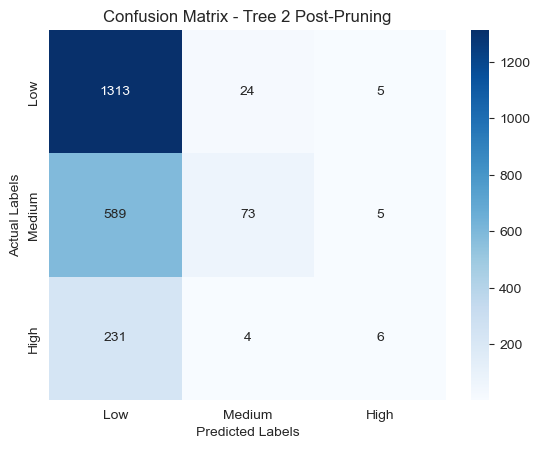

In [203]:
generate_heatmap(cm_after, "Confusion Matrix - Tree 2 Post-Pruning")

#### Tree 3

In [204]:
tree3_clone = copy.deepcopy(id3_3)

In [205]:
print("🔹 Tree 3 - Pre-Pruning")
compute_metrics(cm_3_test)

🔹 Tree 3 - Pre-Pruning


,precision,recall,f1-score,support
Low,0.59,0.93,0.73,1342
Medium,0.21,0.02,0.04,667
High,0.12,0.03,0.05,241
accuracy,0.00,0.00,0.57,2250
macro avg,0.31,0.33,0.27,2250
weighted avg,0.43,0.57,0.45,2250


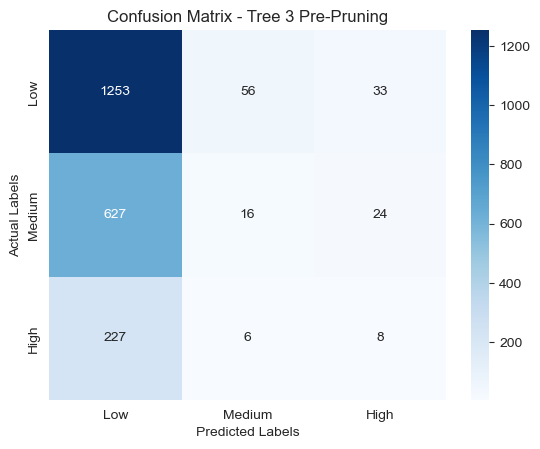

In [206]:
generate_heatmap(cm_3_test, "Confusion Matrix - Tree 3 Pre-Pruning")

In [207]:
prune_tree(tree3_clone, tree3_clone.tree, x_filled_test, y_filled_test)

In [208]:
print("🔹 Tree 3 - Post-Pruning")
y_val_pred_after = tree3_clone.predict(x_filled_test)
cm_after = confusion_matrix(y_filled_test, y_val_pred_after)
display(compute_metrics(cm_after))

🔹 Tree 3 - Post-Pruning


,precision,recall,f1-score,support
Low,0.60,1.00,0.75,1342
Medium,0.00,0.00,0.00,667
High,0.00,0.00,0.00,241
accuracy,0.00,0.00,0.60,2250
macro avg,0.20,0.33,0.25,2250
weighted avg,0.36,0.60,0.45,2250


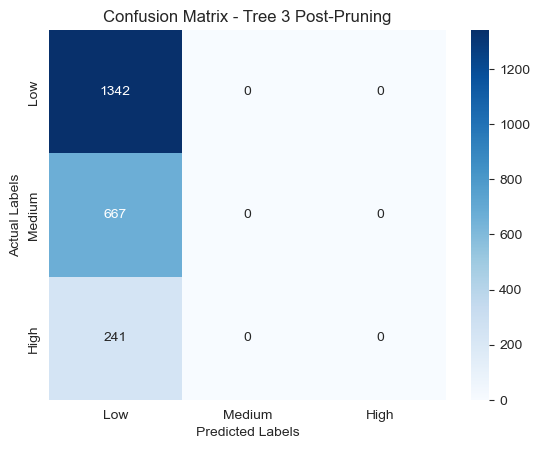

In [209]:
generate_heatmap(cm_after, "Confusion Matrix - Tree 3 Post-Pruning")

#### Tree 4

In [210]:
tree4_clone = copy.deepcopy(id3_4)

In [211]:
print("🔹 Tree 4 - Pre-Pruning")
compute_metrics(cm_4_test)

🔹 Tree 4 - Pre-Pruning


,precision,recall,f1-score,support
Low,0.59,0.96,0.74,1342
Medium,0.25,0.02,0.04,667
High,0.00,0.00,0.00,241
accuracy,0.00,0.00,0.58,2250
macro avg,0.28,0.33,0.26,2250
weighted avg,0.43,0.58,0.45,2250


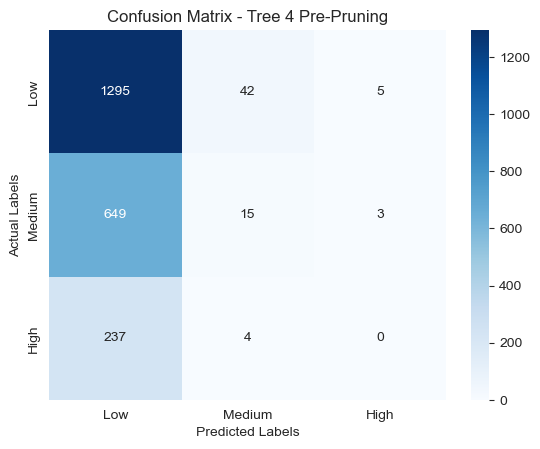

In [212]:
generate_heatmap(cm_4_test, "Confusion Matrix - Tree 4 Pre-Pruning")

In [213]:
prune_tree(tree4_clone, tree4_clone.tree, x_filled_test, y_filled_test)

In [214]:
print("🔹 Tree 4 - Post-Pruning")
y_val_pred_after = tree4_clone.predict(x_filled_test)
cm_after = confusion_matrix(y_filled_test, y_val_pred_after)
display(compute_metrics(cm_after))

🔹 Tree 4 - Post-Pruning


,precision,recall,f1-score,support
Low,0.60,1.00,0.75,1342
Medium,0.00,0.00,0.00,667
High,0.00,0.00,0.00,241
accuracy,0.00,0.00,0.60,2250
macro avg,0.20,0.33,0.25,2250
weighted avg,0.36,0.60,0.45,2250


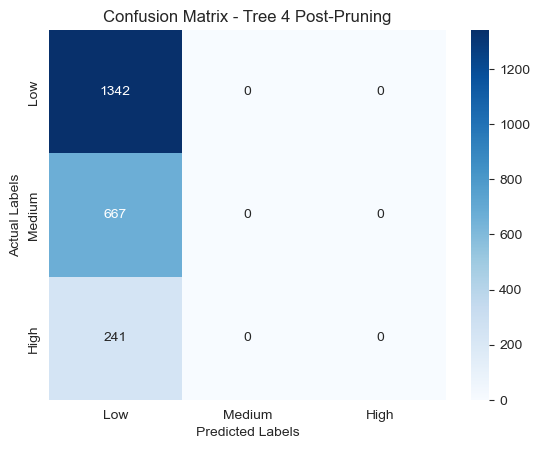

In [215]:
generate_heatmap(cm_after, "Confusion Matrix - Tree 4 Post-Pruning")

## Conclusion

 Part 1 models were one hundred percent correct on the training set and poor performance relatively speaking on the test set with large bias to guess the most frequent "Low" class. This class imbalance resulted in poor generalization for the "Medium" and "High" classes, i.e., overfitting to the training set.

After pruning in Part 2, models were much less complex and tended to predict the "Low" class more often, leading to lower performance on minority classes. Pruning did decrease model complexity and avoid overfitting but also led to a decrease in overall class-wise performance, especially for infrequent classes. This suggests that pruning, while decreasing the model's complexity, decreased its discriminative capacity between classes.

The results reveal that Tree 1, trained on the "dropped" set, maintained the maximum after-pruning accuracy (0.63) but relatively poor F1-score (0.34), indicating while it was quite good at whatever it did, it could still not do enough with the minority classes. Tree 3, trained on the "filled" set, was most uniform before pruning with more stable recall and precision per class but had a sharp F1-score drop-off after pruning. Tree 4, with stricter hyperparameters (higher min_samples_split and min_samples_leaf), was already less specific and experienced less of a performance drop-off after pruning, suggesting it was less prone to overfitting.

Decreases in the F1-scores of all the models along with reductions in their confusion matrices indicate the extent to which overfitting is reduced through pruning but simultaneously show class-wise versus overall model complexity trading-off against class-wise predictions. Macro-average measures are necessary so that all the classes are tried with equal strengths regardless of imbalanced classes.

In [216]:
print("Accuracy Comparison Across Trees")

data = {
    "Tree": ["Tree 1", "Tree 2", "Tree 3", "Tree 4"],
    "Dataset": ["dropped", "filled", "filled", "filled"],
    "Train Accuracy": [1.00, 1.00, 0.66, 0.62],       # Part 1 Train
    "Test Accuracy": [0.57, 0.53, 0.57, 0.58],        # Part 1 Test
    "Test Accuracy (Pruned)": [0.63, 0.62, 0.60, 0.60],   # Part 2 Post-Pruning
}

df = pd.DataFrame(data)

display(df)


Accuracy Comparison Across Trees


,Tree,Dataset,Train Accuracy,Test Accuracy,Test Accuracy (Pruned)
0,Tree 1,dropped,1.00,0.57,0.63
1,Tree 2,filled,1.00,0.53,0.62
2,Tree 3,filled,0.66,0.57,0.60
3,Tree 4,filled,0.62,0.58,0.60


In [217]:
print("Macro F1 Comparison Across Trees")

data = {
    "Tree": ["Tree 1", "Tree 2", "Tree 3", "Tree 4"],
    "Dataset": ["dropped", "filled", "filled", "filled"],
    "Train F1": [1.00, 1.00, 0.52, 0.36],       # Part 1 Train
    "Test F1": [0.32, 0.33, 0.27, 0.26],        # Part 1 Test
    "Test F1 (Pruned)": [0.34, 0.33, 0.25, 0.25],   # Part 2 Post-Pruning
}

df = pd.DataFrame(data)

display(df)

Macro F1 Comparison Across Trees


,Tree,Dataset,Train F1,Test F1,Test F1 (Pruned)
0,Tree 1,dropped,1.00,0.32,0.34
1,Tree 2,filled,1.00,0.33,0.33
2,Tree 3,filled,0.52,0.27,0.25
3,Tree 4,filled,0.36,0.26,0.25


### Comparisions between Pre-Prune and Post-Prune Tree 1

Based on the accuracy and F1 scores, we've decided to choose Pruned Tree 1 with the dataset "dropped" as our best tree with the accuracy value of 0.63 and macro F1 value of 0.34.

In [218]:
print("Accuracy Comparison Pre-Prune Tree 1 vs Post-Prune Tree 1")

data = {
    "Tree": ["Pre-Prune", "Post-Prune"],
    "Train Accuracy": [1.00, 0.63],
    "Test Accuracy": [0.57, 0.63],
    "Validation Accuracy": [0.56, 0.59],
}

df = pd.DataFrame(data)

display(df)

Accuracy Comparison Pre-Prune Tree 1 vs Post-Prune Tree 1


,Tree,Train Accuracy,Test Accuracy,Validation Accuracy
0,Pre-Prune,1.00,0.57,0.56
1,Post-Prune,0.63,0.63,0.59


In [219]:
print("F1 Comparison Pre-Prune Tree 1 vs Post-Prune Tree 1")

data = {
    "Tree": ["Pre-Prune", "Post-Prune"],
    "Train F1": [1.00, 0.39],
    "Test F1": [0.32, 0.34],
    "Validation F1": [0.32, 0.29],
}

df = pd.DataFrame(data)

display(df)

F1 Comparison Pre-Prune Tree 1 vs Post-Prune Tree 1


,Tree,Train F1,Test F1,Validation F1
0,Pre-Prune,1.00,0.32,0.32
1,Post-Prune,0.39,0.34,0.29


In [220]:
print("Pre-Prune Train Accuracy")
y_preprune_train = id3_1.predict(x_dropped_train)
cm_preprune_train = confusion_matrix(y_dropped_train, y_preprune_train)
compute_metrics(cm_preprune_train)

Pre-Prune Train Accuracy


,precision,recall,f1-score,support
Low,1.0,1.0,1.0,2378
Medium,1.0,1.0,1.0,1221
High,1.0,1.0,1.0,402
accuracy,0.0,0.0,1.0,4001
macro avg,1.0,1.0,1.0,4001
weighted avg,1.0,1.0,1.0,4001


In [221]:
print("Post-Prune Train Accuracy")
y_postprune_train = tree1_clone.predict(x_dropped_train)
cm_postprune_train = confusion_matrix(y_dropped_train, y_postprune_train)
compute_metrics(cm_postprune_train)

Post-Prune Train Accuracy


,precision,recall,f1-score,support
Low,0.62,0.97,0.76,2378
Medium,0.66,0.15,0.24,1221
High,0.79,0.08,0.15,402
accuracy,0.00,0.00,0.63,4001
macro avg,0.69,0.40,0.39,4001
weighted avg,0.65,0.63,0.54,4001


In [222]:
print("Pre-Prune Test Accuracy")
y_preprune_test = id3_1.predict(x_dropped_test)
cm_preprune_test = confusion_matrix(y_dropped_test, y_preprune_test)
compute_metrics(cm_preprune_test)

Pre-Prune Test Accuracy


,precision,recall,f1-score,support
Low,0.63,0.87,0.73,527
Medium,0.30,0.13,0.18,249
High,0.10,0.02,0.04,81
accuracy,0.00,0.00,0.57,857
macro avg,0.34,0.34,0.32,857
weighted avg,0.48,0.57,0.50,857


In [223]:
print("Post-Prune Test Accuracy")
y_postprune_test = tree1_clone.predict(x_dropped_test)
cm_postprune_test = confusion_matrix(y_dropped_test, y_postprune_test)
compute_metrics(cm_postprune_test)

Post-Prune Test Accuracy


,precision,recall,f1-score,support
Low,0.64,0.96,0.77,527
Medium,0.58,0.14,0.22,249
High,0.22,0.02,0.04,81
accuracy,0.00,0.00,0.63,857
macro avg,0.48,0.37,0.34,857
weighted avg,0.58,0.63,0.54,857


In [224]:
print("Pre-Prune Validation Accuracy")
y_preprune_val = id3_1.predict(x_dropped_val)
cm_preprune_val = confusion_matrix(y_dropped_val, y_preprune_val)
compute_metrics(cm_preprune_val)

Pre-Prune Validation Accuracy


,precision,recall,f1-score,support
Low,0.61,0.84,0.71,519
Medium,0.34,0.15,0.21,259
High,0.09,0.02,0.04,80
accuracy,0.00,0.00,0.56,858
macro avg,0.34,0.34,0.32,858
weighted avg,0.48,0.56,0.49,858


In [225]:
print("Post-Prune Validation Accuracy")
y_postprune_val = tree1_clone.predict(x_dropped_val)
cm_postprune_val = confusion_matrix(y_dropped_val, y_postprune_val)
compute_metrics(cm_postprune_val)

Post-Prune Validation Accuracy


,precision,recall,f1-score,support
Low,0.61,0.93,0.73,519
Medium,0.37,0.08,0.14,259
High,0.00,0.00,0.00,80
accuracy,0.00,0.00,0.59,858
macro avg,0.33,0.34,0.29,858
weighted avg,0.48,0.59,0.48,858


### Rules For The Post-Prune Tree 1

In [226]:
print_decision_rules(tree1_clone.tree)

R1: IF (Country = Saint Vincent and the Grenadines) THEN Class=Medium
R2: IF (Country = Bangladesh) THEN Class=Low
R3: IF (Country = Canada) THEN Class=Low
R4: IF (Country = Wallis and Futuna) THEN Class=Low
R5: IF (Country = Niger) THEN Class=Low
R6: IF (Country = New Caledonia) THEN Class=Low
R7: IF (Country = Korea) THEN Class=Low
R8: IF (Country = Jordan) THEN Class=Low
R9: IF (Country = Holy See (Vatican City State)) THEN Class=Low
R10: IF (Country = Gambia) THEN Class=Medium
R11: IF (Country = Cameroon) THEN Class=Low
R12: IF (Country = Western Sahara) THEN Class=Low
R13: IF (Country = Saint Kitts and Nevis) THEN Class=Medium
R14: IF (Country = Panama) & (State = WA) THEN Class=Low
R15: IF (Country = Panama) & (State = KY) THEN Class=Medium
R16: IF (Country = Panama) & (State = NE) THEN Class=Medium
R17: IF (Country = Panama) & (State = ME) THEN Class=High
R18: IF (Country = Panama) & (State = WV) THEN Class=High
R19: IF (Country = Panama) & (State = AS) THEN Class=High
R20: IF (